# Multi TARE experiments

In [19]:
import datetime
import os
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

SCENARIO = "indoor"
CUTOFF_TIME_START = datetime.datetime(
    year=2024,
    month=4,
    day=9,
    hour=1,
    minute=30,
    second=20
)
CUTOFF_TIME_END = datetime.datetime(
    year=2024,
    month=4,
    day=13,
    hour=22,
    minute=5
)

In [2]:
DATAFIELDS = ["scenario", "delay_time", "num_robots", "robot_id", "time", "volume_explored", "total_time", "total_volume_explored", "exploration_efficiency", "datetime"]
DELAY_TIME_LOG_PATTERN = r"delayInSeconds:\s+(\d+)"
NUM_ROBOTS_LOG_PATTERN = r"Number of robots:\s+(\d+)"
EXPLORED_VOLUME_LOG_PATTERN = r"\[Global\] (\d+\.\d+): (\d+\.\d+)"
EXPLORATION_COMPLETED_LOG_PATTERN = r"Exploration completed, returning home"
EXPLORATION_RESTARTED_LOG_PATTERN = r"Restarting exploration"
WINDOW_SIZE = 100

Datetime comparison utils funcs

In [3]:
def is_date_inside_cutoff(
    datetime_: datetime.datetime,
    cutoff_datetime_start: datetime.datetime,
    cutoff_datetime_end: datetime.datetime,
) -> bool:
    return cutoff_datetime_start < datetime_ < cutoff_datetime_end

def str_to_datetime(datetime_str: str) -> datetime.datetime:
    return datetime.datetime.strptime(datetime_str, "%Y-%m-%d_%H-%M-%S")

Logs loading utils func

In [4]:
def get_experiments_logs(
    base_logs_dir: str,
    cutoff_datetime_start: datetime.datetime,
    cutoff_datetime_end: datetime.datetime,
) -> list[str]:
    logs_dirs = os.listdir(base_logs_dir)
    filter_func = lambda x: is_date_inside_cutoff(str_to_datetime(x), cutoff_datetime_start, cutoff_datetime_end)
    return list(filter(filter_func, logs_dirs))

In [5]:
def read_logs(
    experiment_logs_dir: str,
    logs_filename: str,
) -> list[str] | None:
    logs_filepath = os.path.join(experiment_logs_dir, logs_filename)
    if not os.path.exists(logs_filepath):
        return None
    with open(logs_filepath, 'r') as file:
        lines = file.readlines()
    return lines

Logs extraction

In [6]:
def get_delay_time_and_num_robots(planner_logs: list[str],) -> tuple[int, int]:
    delay_time = num_robots = None
    for log in planner_logs:
        delay_time_match = re.search(DELAY_TIME_LOG_PATTERN, log)
        if delay_time_match:
            delay_time = int(delay_time_match.group(1))
        num_robots_match = re.search(NUM_ROBOTS_LOG_PATTERN, log)
        if num_robots_match:
            num_robots = int(num_robots_match.group(1))
    if delay_time is None:
        raise RuntimeError("No delay time found")
    if num_robots is None:
        raise RuntimeError("No num robots found")
    return delay_time, num_robots

In [7]:
def get_time_and_explored_volume(robot_logs: list[str]) -> tuple[list[tuple[float, float]], float, float]:
    times_and_explored_volumes = []
    time = explored_volume = 0
    time_at_exploration_completed = 0
    explored_volume_at_exploration_completed = 0
    exploration_stopped = False
    for log in robot_logs:
        match = re.search(EXPLORED_VOLUME_LOG_PATTERN, log)
        if match:
            time = float(match.group(1))
            explored_volume = float(match.group(2))
            times_and_explored_volumes.append((time, explored_volume))
        if re.search(EXPLORATION_COMPLETED_LOG_PATTERN, log):
            exploration_stopped = True
            time_at_exploration_completed = time
            explored_volume_at_exploration_completed = explored_volume
        if re.search(EXPLORATION_RESTARTED_LOG_PATTERN, log):
            exploration_stopped = False
            
    if explored_volume_at_exploration_completed == 0 or not exploration_stopped:
        time_at_exploration_completed = time
        explored_volume_at_exploration_completed = explored_volume
    return times_and_explored_volumes, time_at_exploration_completed, explored_volume_at_exploration_completed

In [8]:
def calc_exploration_efficiency(times_and_explored_volumes: tuple[float, float]) -> tuple[float, float, float]:
    times = [i[0] for i in times_and_explored_volumes]
    explored_volumes = [i[1] for i in times_and_explored_volumes]
    exploration_efficiency = max(explored_volumes) / max(times)
    data = [(i[0], i[1], exploration_efficiency) for i in times_and_explored_volumes]
# def calc_exploration_efficiency(times_and_explored_volumes: list[tuple[float, float]]) -> list[tuple[float, float, float]]:
#     if len(times_and_explored_volumes) < WINDOW_SIZE:
#         return [(i[0], i[1], 0) for i in times_and_explored_volumes]
#         return (0, 0, 0)
#     data = [(times_and_explored_volumes[i][0], times_and_explored_volumes[i][1], 0) for i in range(WINDOW_SIZE)]
#     for i in range(len(times_and_explored_volumes) - WINDOW_SIZE):
#         d_vol = (times_and_explored_volumes[i + WINDOW_SIZE][1] - times_and_explored_volumes[i][1])
#         d_t = (times_and_explored_volumes[i + WINDOW_SIZE][0] - times_and_explored_volumes[i][0])
#         exploration_efficiency = d_vol / d_t
#         data.append((times_and_explored_volumes[i + WINDOW_SIZE][0], times_and_explored_volumes[i + WINDOW_SIZE][1], exploration_efficiency))
    return data

In [9]:
def extract_global_exploration_data(
    base_logs_dir: str,
    experiment_logs_dir_name: str,
) -> pd.DataFrame:
    experiment_logs_dir = os.path.join(base_logs_dir, experiment_logs_dir_name)
    planner_logs = read_logs(experiment_logs_dir, "planner.log")
    if planner_logs:
        delay_time, num_robots_ = get_delay_time_and_num_robots(planner_logs)
    else:
        delay_time = 0
        num_robots_ = 1
    data = []
    total_times = []
    total_volumes =[]
    for robot_id in range(num_robots_):
        robot_logs = read_logs(experiment_logs_dir, f"robot_{robot_id}.log")
        times_and_explored_volumes, total_time, total_vol = get_time_and_explored_volume(robot_logs)
        total_times.append(total_time)
        total_volumes.append(total_vol)
        data.append(times_and_explored_volumes)
    max_total_time = max(total_times)
    max_total_vol = max(total_volumes)
    exploration_efficiency = max_total_vol / max_total_time
    data_with_exploration_eff = []
    for robot_id, d in enumerate(data):
        data_with_exploration_eff.extend([(
            SCENARIO,
            delay_time,
            num_robots_,
            robot_id,
            i[0], i[1],
            total_times[robot_id],
            total_volumes[robot_id],
            exploration_efficiency,
            experiment_logs_dir_name
        ) for i in d])
    return pd.DataFrame(data_with_exploration_eff, columns=DATAFIELDS)

In [21]:
experiment_logs = get_experiments_logs("../logs", CUTOFF_TIME_START, CUTOFF_TIME_END)
df = extract_global_exploration_data("../logs", experiment_logs[0])
for logs in tqdm(experiment_logs, ncols=80):
    df = pd.concat([df, extract_global_exploration_data("../logs", logs)])
# df = df[df["total_volume_explored"]>2000]
# df = df[df["exploration_efficiency"]>0]
df.describe()

100%|█████████████████████████████████████████| 220/220 [00:08<00:00, 25.84it/s]


,delay_time,num_robots,robot_id,time,volume_explored,total_time,total_volume_explored,exploration_efficiency
count,229238.000000,229238.000000,229238.000000,229238.000000,229238.000000,229238.000000,229238.000000,229238.000000
mean,14.779138,3.183979,1.087603,181.986238,1495.170084,331.513064,2568.031804,7.521251
std,10.055871,0.826873,0.995334,104.642687,955.946967,76.794658,869.438805,1.894344
min,0.000000,1.000000,0.000000,0.202663,0.000000,16.466919,71.361000,1.941385
25%,5.000000,3.000000,0.000000,91.562717,701.487000,361.700143,2137.670898,6.260536
50%,15.000000,3.000000,1.000000,181.903333,1431.458984,362.794684,2750.138916,7.789404
75%,25.000000,4.000000,2.000000,272.642296,2210.543945,362.987734,3172.122070,8.828882
max,30.000000,4.000000,3.000000,363.571180,4237.893066,363.571180,4237.893066,11.672124


In [27]:
df = df[df["total_time"]>200]

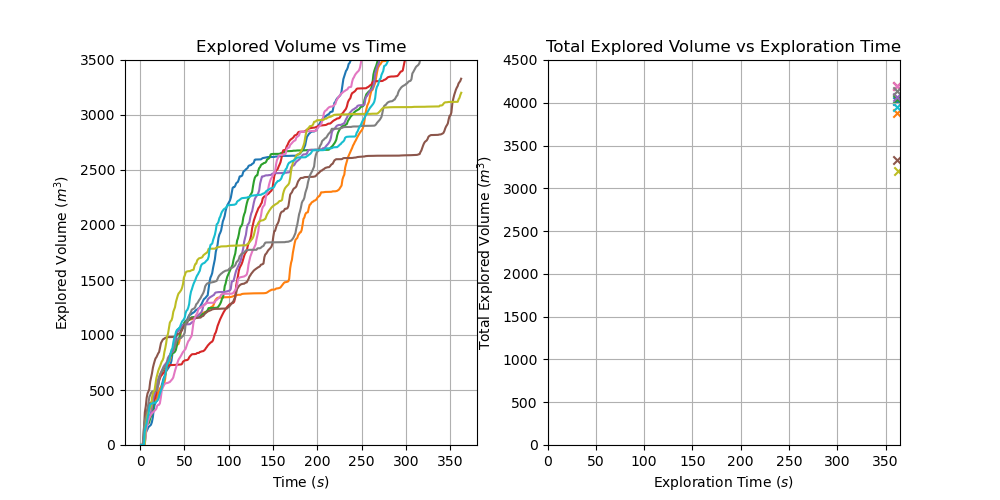

In [24]:
%matplotlib widget
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for date in df["datetime"].unique():
    total_times = []
    total_volumes = []
    exp_df = df[df["datetime"]==date]
    num_robots_ = exp_df["num_robots"].mode()[0]
    delay_time = exp_df["delay_time"].mode()[0]
    if (num_robots_, delay_time) not in [(1,0)]:
        continue
    for robot_id in range(num_robots_):
        robot_df = exp_df[exp_df["robot_id"] == robot_id]
        axes[0].plot(robot_df["time"].values, robot_df["volume_explored"].values, label=f"{date}_{robot_id}")
        total_times.append(robot_df["total_time"].max())
        total_volumes.append(robot_df["total_volume_explored"].max())
    axes[1].scatter(total_times, total_volumes, marker='x', label=f"{date}_{robot_id}")

axes[0].set_xlabel("Time ($s$)")
axes[0].set_ylabel("Explored Volume ($m^3$)")
axes[0].set_title("Explored Volume vs Time")
axes[0].grid(True)
axes[0].set_ylim([0,3500])
# axes[1].legend()
axes[1].set_xlabel("Exploration Time ($s$)")
axes[1].set_ylabel("Total Explored Volume ($m^3$)")
axes[1].set_title("Total Explored Volume vs Exploration Time")
axes[1].set_xlim([0,365])
axes[1].set_ylim([0,4500])
axes[1].grid(True)
plt.show()

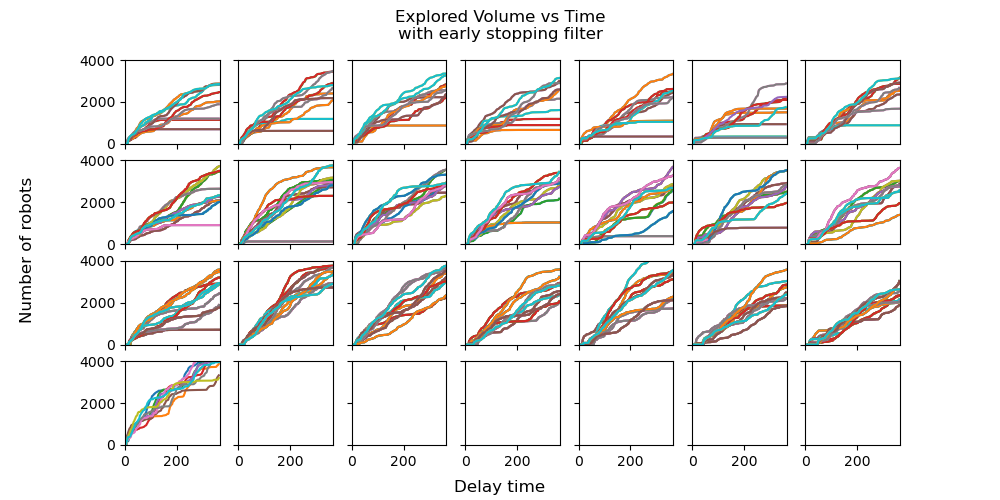

In [25]:
%matplotlib widget

num_robots = df["num_robots"].unique()
delay_times = df["delay_time"].unique()
num_robots.sort()
delay_times.sort()
fig, axes = plt.subplots(nrows=len(num_robots), ncols=len(delay_times), figsize=(10, 5), sharey=True, sharex=True)
axes[0][0].set_xlim([0,365])
axes[0][0].set_ylim([0,4000])

for date in df["datetime"].unique():
    exp_df = df[df["datetime"]==date]
    num_robots_ = exp_df["num_robots"].mode()[0]
    delay_time = exp_df["delay_time"].mode()[0]
    for robot_id in range(num_robots_):
        robot_df = exp_df[exp_df["robot_id"] == robot_id]
        axes[num_robots_-2][delay_time//5].plot(robot_df["time"].values, robot_df["volume_explored"].values)


fig.supxlabel("Delay time")
fig.supylabel("Number of robots")
fig.suptitle("Explored Volume vs Time\nwith early stopping filter")

plt.show()

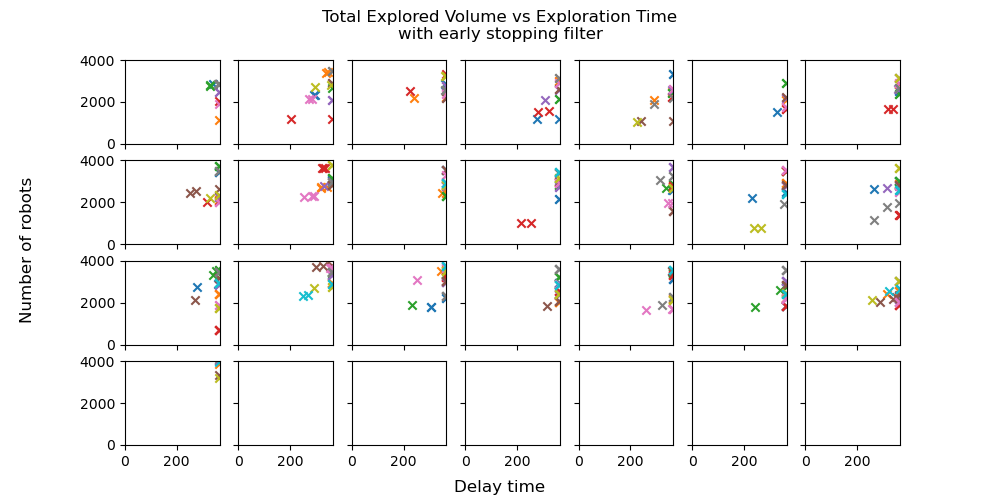

In [28]:
%matplotlib widget

num_robots = df["num_robots"].unique()
delay_times = df["delay_time"].unique()
num_robots.sort()
delay_times.sort()
fig, axes = plt.subplots(nrows=len(num_robots), ncols=len(delay_times), figsize=(10, 5), sharey=True, sharex=True)
axes[0][0].set_xlim([0,365])
axes[0][0].set_ylim([0,4000])

for date in df["datetime"].unique():
    exp_df = df[df["datetime"]==date]
    num_robots_ = exp_df["num_robots"].mode()[0]
    delay_time = exp_df["delay_time"].mode()[0]
    total_times = []
    total_volumes = []
    for robot_id in range(num_robots_):
        robot_df = exp_df[exp_df["robot_id"] == robot_id]
        total_times.append(robot_df["total_time"].max())
        total_volumes.append(robot_df["total_volume_explored"].max())
    axes[num_robots_-2][delay_time//5].scatter(total_times, total_volumes, marker='x', label=f"{date}_{robot_id}")
fig.supxlabel("Delay time")
fig.supylabel("Number of robots")
fig.suptitle("Total Explored Volume vs Exploration Time\nwith early stopping filter")

plt.show()

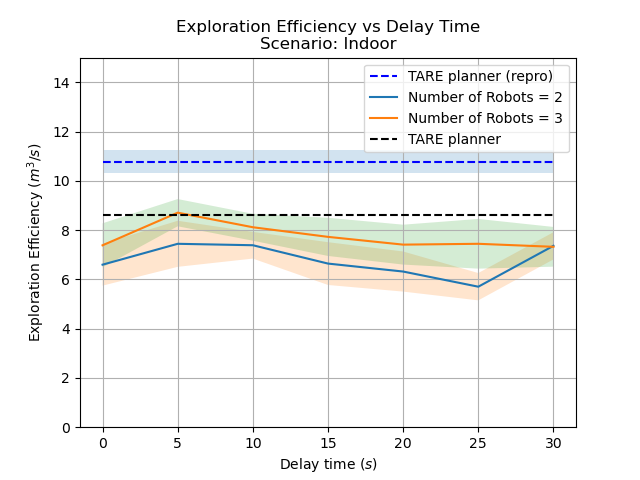

In [31]:
%matplotlib widget

num_robots.sort()
delay_times.sort()
plot_data = {}

colors = ["blue", "green", "red"]


for j, color in zip(num_robots, colors):
    exploration_efficiency_mean = []
    exploration_efficiency_min = []
    exploration_efficiency_std = []
    df_ = df[df["num_robots"] == j]

    if j == 1:
        exploration_efficiency_mean = df_["exploration_efficiency"].unique().mean()
        exploration_efficiency_std = df_["exploration_efficiency"].unique().std()
        plt.hlines([exploration_efficiency_mean], 0, 30, linestyles='--', color='b', label="TARE planner (repro)")
        plt.fill_between(
            delay_times,
            exploration_efficiency_mean-0.5*exploration_efficiency_std,
            exploration_efficiency_mean+0.5*exploration_efficiency_std,
            alpha=0.2)
        continue

    for i, delay_time in enumerate(delay_times):
        df_delay_time = df_[df_["delay_time"]==delay_time]
        top_k = int(len(df_delay_time) * 0.5)
        exploration_efficiency_min.append(df_delay_time["exploration_efficiency"].unique().min())
        exploration_efficiency_mean.append(df_delay_time["exploration_efficiency"].unique().mean())
        exploration_efficiency_std.append(df_delay_time["exploration_efficiency"].unique().std())

    exploration_efficiency_mean = np.array(exploration_efficiency_mean)
    exploration_efficiency_std = np.array(exploration_efficiency_std)
    # plt.plot(delay_times, exploration_efficiency_min, linestyle='--', color=color)
    plt.plot(delay_times, exploration_efficiency_mean, label=f"Number of Robots = {j}")
    plt.fill_between(
        delay_times,
        exploration_efficiency_mean-0.5*exploration_efficiency_std,
        exploration_efficiency_mean+0.5*exploration_efficiency_std,
        alpha=0.2)

plt.hlines([8.6], 0, 30, linestyles='--', color='k', label="TARE planner")

plt.xlabel("Delay time ($s$)")
plt.ylabel("Exploration Efficiency ($m^3/s$)")
plt.title("Exploration Efficiency vs Delay Time\nScenario: Indoor")
plt.ylim([0,15])
plt.grid()
plt.legend()
plt.show()
# plt.savefig("garage_ylim.png")

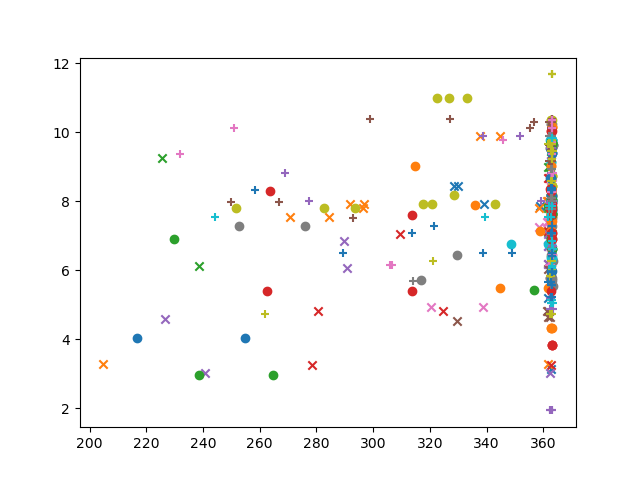

In [16]:
%matplotlib widget

for j, marker in zip(num_robots,['x','o','+']):
    exploration_efficiency_mean = []
    exploration_efficiency_std = []
    num_robots_df = df[df["num_robots"] == j]
    total_times = []
    total_volumes = []
    for i, delay_time in enumerate(delay_times):
        delay_time_df = num_robots_df[num_robots_df["delay_time"]==delay_time]
        delay_time_df = delay_time_df[["total_time", "exploration_efficiency"]].drop_duplicates()
        plt.scatter(delay_time_df["total_time"], delay_time_df["exploration_efficiency"], marker=marker, facecolor=None)

plt.show()

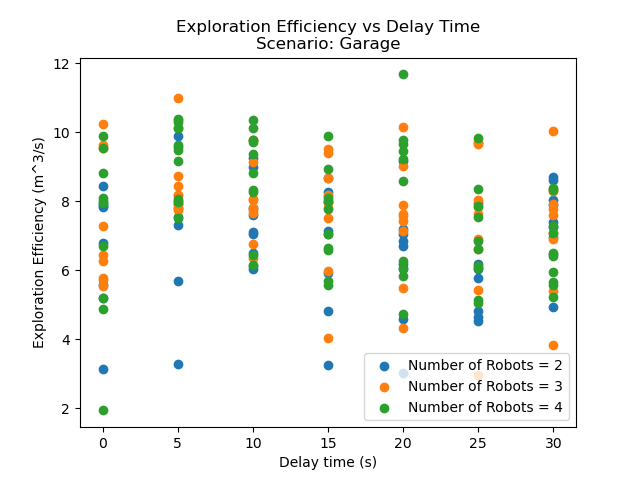

In [17]:
%matplotlib widget

for j in num_robots:
    delay_times_ = []
    exp_efficiency = []
    df_ = df[df["num_robots"] == j]
    for delay_time in delay_times:
        df_delay_time = df_[df_["delay_time"]==delay_time]
        exp_eff_at_delay_time = df_delay_time["exploration_efficiency"]
        for k in exp_eff_at_delay_time.unique():
            exp_efficiency.append(k)
            delay_times_.append(delay_time)
    
    plt.scatter(delay_times_, exp_efficiency, label=f"Number of Robots = {j}")

plt.xlabel("Delay time (s)")
plt.ylabel("Exploration Efficiency (m^3/s)")
plt.title("Exploration Efficiency vs Delay Time\nScenario: Garage")
plt.legend()
plt.show()

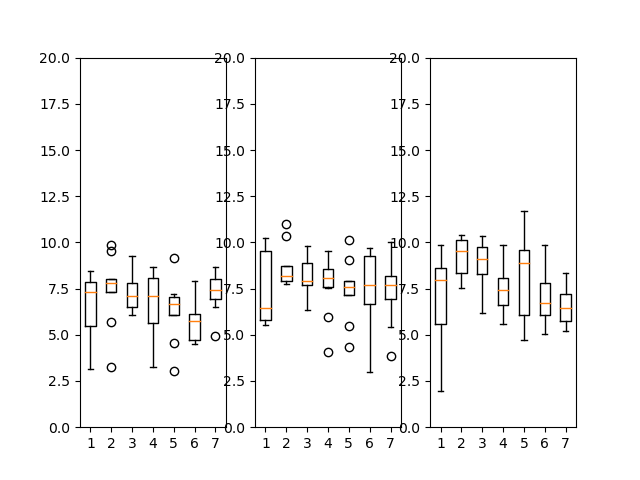

In [18]:
%matplotlib widget

fig, ax = plt.subplots(ncols=len(num_robots))

for i, j in enumerate(num_robots):
    exp_eff = []
    df_ = df[df["num_robots"] == j]
    for delay_time in delay_times:
        df_delay_time = df_[df_["delay_time"]==delay_time]
        exp_eff_at_delay_time = df_delay_time["exploration_efficiency"]
        exp_eff.append(exp_eff_at_delay_time.unique())
    ax[i].boxplot(exp_eff)
    ax[i].set_ylim([0,20])

plt.show()